In [1]:
import warnings
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn import preprocessing
import math

In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')

In [3]:
# US cases records
df_confirmed_us = confirmed_df.loc[confirmed_df["Country/Region"]=="US"]
df_confirmed_us = df_confirmed_us.drop(columns=['Province/State', 'Lat','Long','Country/Region'])
df_confirmed_us = df_confirmed_us.transpose()
column_head = int(df_confirmed_us.columns[0])
df_confirmed_us = df_confirmed_us.rename(columns={column_head: "US"})
df_confirmed_us.index = pd.to_datetime(df_confirmed_us.index)
df_conf_daily_us = df_confirmed_us.diff()
df_conf_daily_us['US'] = df_conf_daily_us['US'].replace(np.nan, 1)
df_conf_daily_us = df_conf_daily_us.loc[:'2021-02-23']
df_conf_daily_us

,US
2020-01-22,1.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,3.0
...,...
2021-02-19,79297.0
2021-02-20,71525.0
2021-02-21,57080.0
2021-02-22,56220.0


In [4]:
# 80% training set and 20% test set
bound = int(len(df_conf_daily_us.index)*0.8)-1
train, test = df_conf_daily_us.loc[:df_conf_daily_us.index[bound]], df_conf_daily_us.loc[df_conf_daily_us.index[bound+1]:]

In [5]:
train.head()

,US
2020-01-22,1.0
2020-01-23,0.0
2020-01-24,1.0
2020-01-25,0.0
2020-01-26,3.0


In [7]:
train.describe()

,US
count,319.000000
mean,46185.103448
std,46694.901213
min,0.000000
25%,19734.500000
50%,34428.000000
75%,56793.500000
max,232785.000000


In [6]:
test

,US
2020-12-06,181012.0
2020-12-07,194858.0
2020-12-08,224492.0
2020-12-09,222539.0
2020-12-10,231515.0
...,...
2021-02-19,79297.0
2021-02-20,71525.0
2021-02-21,57080.0
2021-02-22,56220.0


In [8]:
test.describe()

,US
count,80.000000
mean,169627.312500
std,63775.419291
min,54186.000000
25%,114499.000000
50%,182124.000000
75%,223027.250000
max,300310.000000


# ARIMA model

In [14]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


# all set

In [15]:
# model selection

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_conf_daily_us["US"],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:10297.394792168707
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:9768.558209990102
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:9120.193413570676
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:8850.517408822856
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:9137.242164209149
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:9116.59108775024
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:8872.980099976143
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:8851.013405533991
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:10007.339030480478
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:9650.366950596326
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:8986.037870737404
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:8705.191562943339
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:9658.59265235142
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:9610.097408906768
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:8748.68243401837
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:8705.666408777612
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:8938.060723767074
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:8679.521662142482
ARIMA(0, 1,

# train set 

In [8]:
# model selection

warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train["US"],
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:7959.771905614745
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:7486.015481554616
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:6934.756978638399
ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:6644.0771675705855
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:6896.4954866370645
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:6874.5063085317925
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:6654.340477359937
ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:6634.355687981896
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:7728.640690967339
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:7386.737426446374
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:6801.078675310888
ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:6543.854890384781
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:7398.330607173978
ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:7351.853380117678
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:6586.303535733639
ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:6517.738763130306
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:6785.281316974024
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:6529.633949154091
ARIMA(0

# whole set

In [16]:
# Choose the best model with lowest AIC score

tic1 = time.perf_counter()
mod = sm.tsa.statespace.SARIMAX(df_conf_daily_us["US"],
                                order=(1, 1, 1),
                                seasonal_order=(0, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

toc2 = time.perf_counter()

print(f"Model fitting time: {toc2 - tic1: 0.4f} seconds.")
print(results.summary().tables[1])

Model fitting time:  0.9000 seconds.
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1008      0.099      1.021      0.307      -0.093       0.294
ma.L1         -0.6308      0.095     -6.607      0.000      -0.818      -0.444
ma.S.L12      -1.0038      0.047    -21.134      0.000      -1.097      -0.911
sigma2      6.247e+08   1.07e-10   5.82e+18      0.000    6.25e+08    6.25e+08


# train set

In [9]:
# Choose the best model with lowest AIC score

tic1 = time.perf_counter()
mod = sm.tsa.statespace.SARIMAX(train["US"],
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 1, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

toc2 = time.perf_counter()

print(f"Model fitting time: {toc2 - tic1: 0.4f} seconds.")
print(results.summary().tables[1])

Model fitting time:  1.0648 seconds.
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2609      0.157      1.659      0.097      -0.047       0.569
ma.L1         -0.6077      0.140     -4.341      0.000      -0.882      -0.333
ar.S.L12      -0.4662      0.096     -4.861      0.000      -0.654      -0.278
ma.S.L12      -0.7380      0.085     -8.651      0.000      -0.905      -0.571
sigma2      1.831e+08   4.36e-10   4.19e+17      0.000    1.83e+08    1.83e+08


In [29]:
# Validate the forecasting

tic1 = time.perf_counter()
pred = results.get_prediction(start=pd.to_datetime('12/06/2020'), end=pd.to_datetime('02/23/2021'), dynamic=False)
toc2 = time.perf_counter()

print(f"Prediction time: {toc2 - tic1: 0.4f} seconds.")
pred_ci = pred.conf_int()

Prediction time:  0.0022 seconds.


# whole set

In [22]:
# Calculate the RMSE and accuracy 

actual_cases = test["US"]

# RMSE 
print("Before normalized:")
MSE = np.square(np.subtract(actual_cases.values, pred.predicted_mean.values)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)
print("After normalized")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(actual_cases.values.reshape(-1,1))
pred_scaled = min_max_scaler.fit_transform(pred.predicted_mean.values.reshape(-1,1))
MSE = np.square(np.subtract(x_scaled, pred_scaled)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

print("=========================")

# R2 score
acc_r2 = r2_score(actual_cases,pred.predicted_mean)
print("R2: ", acc_r2)

# Accuracy
acc = 100 - mean_absolute_percentage_error(actual_cases,pred.predicted_mean)
print(f"Accuracy: {acc: 0.4f} %.")

#MAPE
mape = mean_absolute_percentage_error(actual_cases,pred.predicted_mean)
print(f"MAPE: {mape: 0.4f} %.")

Before normalized:
RMSE:  31152.39270131946
After normalized
RMSE:  0.15013766843606505
R2:  0.7582784725618922
Accuracy:  99.8558 %.
MAPE:  0.1442 %.


# train set

In [13]:
# Calculate the RMSE and accuracy 

actual_cases = test["US"]

# RMSE 
print("Before normalized:")
MSE = np.square(np.subtract(actual_cases.values, pred.predicted_mean.values)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)
print("After normalized")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(actual_cases.values.reshape(-1,1))
pred_scaled = min_max_scaler.fit_transform(pred.predicted_mean.values.reshape(-1,1))
MSE = np.square(np.subtract(x_scaled, pred_scaled)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

print("=========================")

# R2 score
acc_r2 = r2_score(actual_cases,pred.predicted_mean)
print("R2: ", acc_r2)

# Accuracy
acc = 100 - mean_absolute_percentage_error(actual_cases,pred.predicted_mean)
print(f"Accuracy: {acc: 0.4f} %.")

#MAPE
mape = mean_absolute_percentage_error(actual_cases,pred.predicted_mean)
print(f"MAPE: {mape: 0.4f} %.")

Before normalized:
RMSE:  173161.3303083897
After normalized
RMSE:  0.5166694651412967
R2:  -6.468516407401044
Accuracy:  98.6590 %.
MAPE:  1.3410 %.


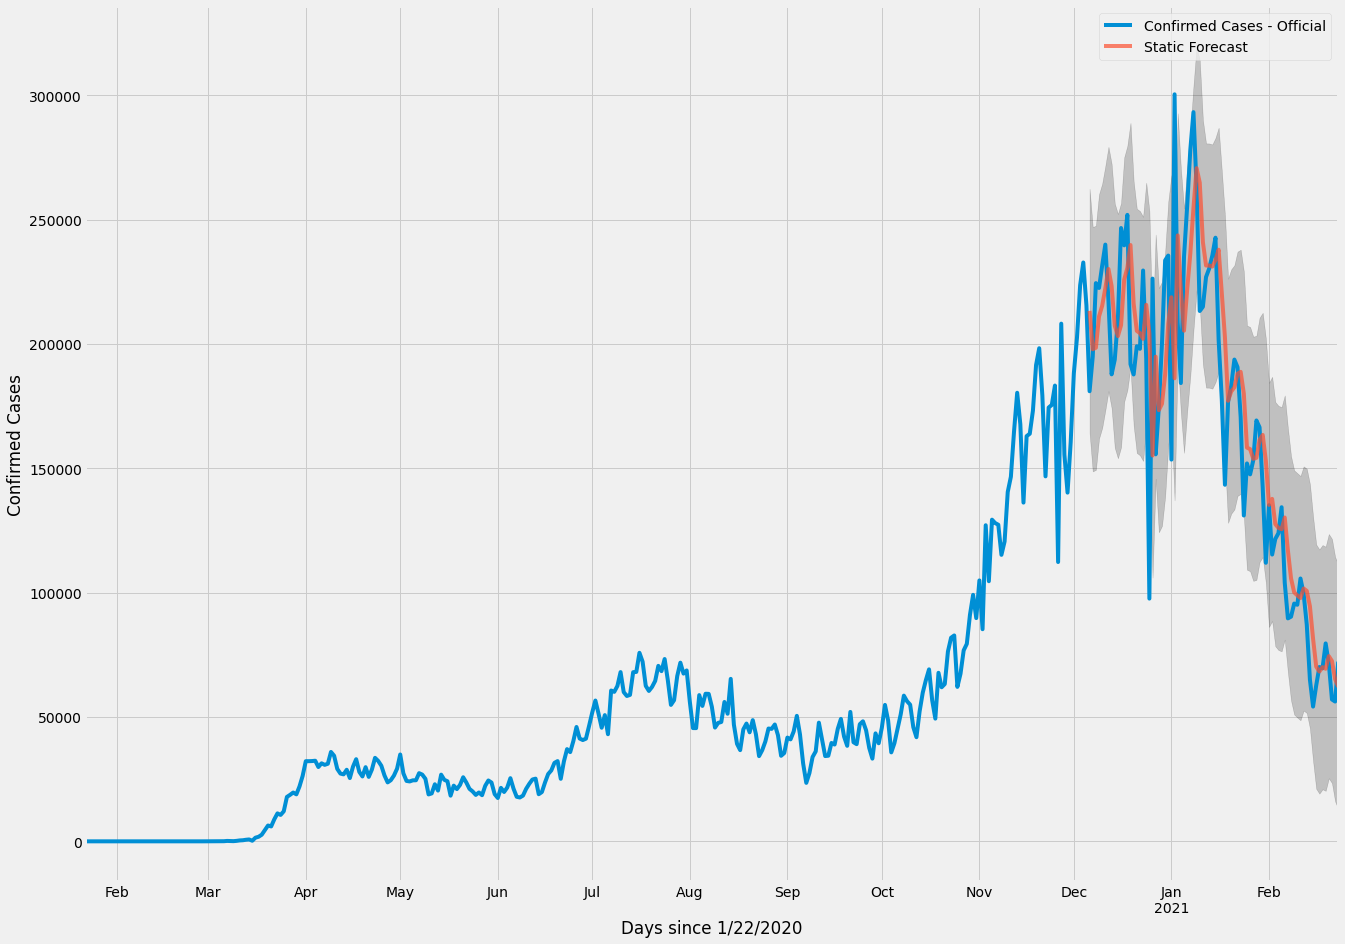

In [24]:
plt.figure(figsize=(20, 15))
plt.style.use('fivethirtyeight')
ax = df_conf_daily_us["US"].plot(label='Confirmed Cases - Official')
pred.predicted_mean.plot(ax=ax, label='Static Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Days since 1/22/2020')
ax.set_ylabel('Confirmed Cases')
plt.legend()

plt.savefig("ARIMA-confimed-3.tiff")
plt.savefig("ARIMA-confimed-3.png")
plt.show()

# LSTM

In [5]:
import pandas as pd
from sklearn.metrics import mean_squared_error,  r2_score
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy as np
import time

In [7]:
# date-time parsing function for loading the dataset
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model

# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

In [8]:
# load dataset
series = df_conf_daily_us["US"]

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

# split data into train and test-sets
bound = int(-len(series)*0.2)
train, test = supervised_values[0:bound], supervised_values[bound:]

# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

# fit the model
tic1 = time.perf_counter()
lstm_model = fit_lstm(train_scaled, 1, 150, 4)
toc2 = time.perf_counter()
print(f"Model fitting time: {toc2 - tic1: 0.4f} seconds.")

# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)


tic1 = time.perf_counter()
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
toc2 = time.perf_counter()
print(f"Prediction time: {toc2 - tic1: 0.4f} seconds.")

Model fitting time:  65.8225 seconds.
Month=1, Predicted=207713.311803, Expected=194861.000000
Month=2, Predicted=196594.992050, Expected=224490.000000
Month=3, Predicted=227090.079196, Expected=222535.000000
Month=4, Predicted=224106.944157, Expected=231516.000000
Month=5, Predicted=233288.767601, Expected=239976.000000
Month=6, Predicted=240291.497494, Expected=217385.000000
Month=7, Predicted=227683.799834, Expected=187804.000000
Month=8, Predicted=221391.773658, Expected=193712.000000
Month=9, Predicted=200139.071652, Expected=210104.000000
Month=10, Predicted=214835.247886, Expected=246644.000000
Month=11, Predicted=248493.064549, Expected=239678.000000
Month=12, Predicted=241662.833667, Expected=251935.000000
Month=13, Predicted=253994.683804, Expected=191894.000000
Month=14, Predicted=249893.796762, Expected=187746.000000
Month=15, Predicted=203115.317551, Expected=199099.000000
Month=16, Predicted=208470.721461, Expected=198067.000000
Month=17, Predicted=211468.445002, Expected

In [9]:
# RMSE 
print("Before normalized:")
MSE = np.square(np.subtract(raw_values[bound:], predictions)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)
print("After normalized")
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(raw_values[bound:].reshape(-1,1))
pred_scaled = min_max_scaler.fit_transform(np.array(predictions).reshape(-1,1))
MSE = np.square(np.subtract(x_scaled, pred_scaled)).mean() 
RMSE = math.sqrt(MSE)
print("RMSE: ", RMSE)

print("===================")
# R2 score
acc_r2 = r2_score(list(raw_values[bound:]), predictions)
print("R2: ", acc_r2)

# Accuracy
acc = 100 - mean_absolute_percentage_error(list(raw_values[bound:]), predictions)
print(f"Accuracy: {acc: 0.4f} %.")

#MAPE
mape = mean_absolute_percentage_error(list(raw_values[bound:]), predictions)
print(f"MAPE: {mape: 0.4f} %.")

Before normalized:
RMSE:  37043.21438020337
After normalized
RMSE:  0.15298638997515435
R2:  0.6623513285187298
Accuracy:  99.8114 %.
MAPE:  0.1886 %.


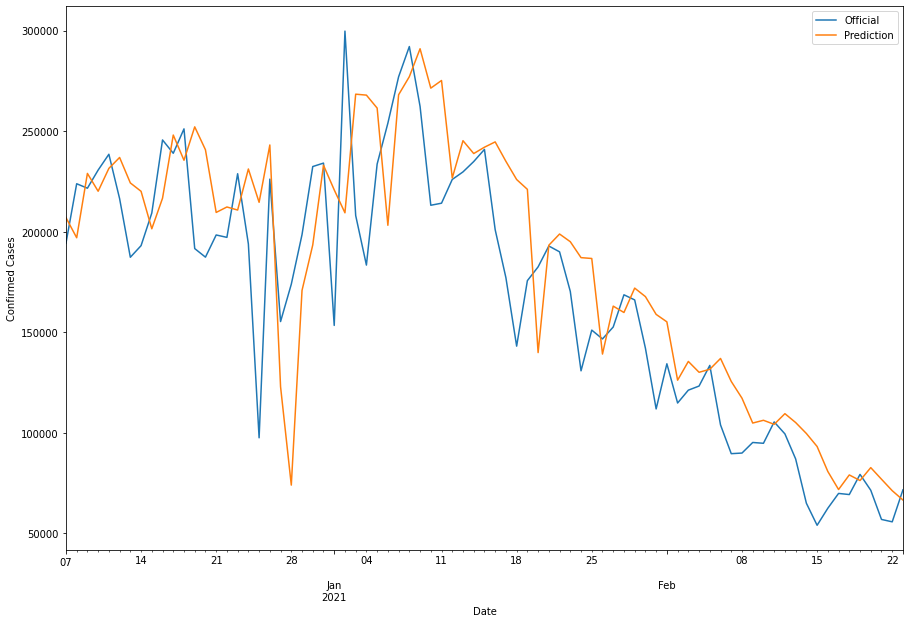

In [12]:
df_pred = pd.DataFrame(data={"Date":df_conf_daily_us.index[bound:],"Official":raw_values[bound:], "Prediction":predictions})
df_pred = df_pred.set_index('Date')
df_pred.plot(figsize=(15,10))
plt.ylabel('Confirmed Cases')
plt.savefig("LSTM-confimed.tiff")